## Students
Please fill in your names and S/U-numbers:
* Linda Schmeitz, S1042449
* Enrico Schmitz, s1047521
* Charlotte Cambier van Nooten, s1044122

# Statistical Machine Learning 2020
# Assignment 4
# Deadline: 23 December 2020
## Instructions
* You can __work in groups__ (= max 3 people). __Write the full name and S/U-number of all team members in the header above.__
* Make sure you __fill in any place that says__ `YOUR CODE HERE` or "YOUR ANSWER HERE" __including comments, derivations, explanations, graphs, etc.__ This means that the elements and/or intermediate steps required to derive the answer have to be in the report. (Answers like 'No' or 'x=27.2' by themselves are not sufficient, even when they are the result of running your code.) If an exercise requires coding, explain briefly what the code does (in comments). All figures should have titles (descriptions), axis labels, and legends (if applicable).
* Please do not add new cells unless necessary, try to write the answers only in the provided cells. Before you turn this problem in, __make sure everything runs as expected__. First, *restart the kernel* (in the menubar, select Kernel$\rightarrow$Restart) and then *run all cells* (in the menubar, select Cell$\rightarrow$Run All). The assignment was written in (and we strongly recommend using) Python 3 by using the corresponding Python 3 kernel for Jupyter.
* The assignment includes certain cells that contain tests. Most of the tests are marked as *hidden* and are used for automatic grading. NB: These hidden tests do not provide any feedback! There are also a couple of tests / checks that are visible, which are meant to help you avoid basic coding errors.
* __Upload the exercises to Brightspace as a single .zip file containing the submitter's S/U-number: 'SML20_as04_&lt;S/U-number&gt;.zip'__, for example 'SML20_as04_S123456.zip'. For those working in groups, it is sufficient if one team member uploads the solutions.
* For any problems or questions, send us an email, or just ask. Email addresses: G.Bucur@cs.ru.nl, Yuliya.Shapovalova@ru.nl, and tomc@cs.ru.nl.

## Introduction
Assignment 4 consists of:
1. __Gaussian processes (50 points)__;
2. EM and doping (50 points);
3. Gibbs sampling and Metropolis-Hastings (50 points);
4. Variational inference for Bayesian linear regression (50 points).

## Libraries

First, we import the basic libraries necessary to develop this assignment. Of course you are free to import further libraries, if required, in the allotted cells.

In [ ]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it to at least version 3."

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set fixed random seed for reproducibility
np.random.seed(2020)

## Gaussian processes (50 points)
### Part 1 - Sampling from Gaussian stochastic processes
One widely used kernel function for Gaussian process regression is given by the exponential of a quadratic form, with the addition of constant and linear terms (eq. 6.63 Bishop):
$$$
    k(\mathbf{x}, \mathbf{x'}) = \theta_0 \exp\left( - \frac{\theta_1}{2} || \mathbf{x} - \mathbf{x'} ||^2 \right) + \theta_2 + \theta_3 \mathbf{x}^T \mathbf{x'}
$$$
We denote by $\boldsymbol{\theta} = (\theta_0, \theta_1, \theta_2, \theta_3)$ the hyperparameter vector governing the kernel function $k$. 

1. Implement the kernel given by equation \eqref{eqn:kernel} as a function of $\mathbf{x}$, $\mathbf{x'}$ and $\mathbf{\theta}$. Note that $\mathbf{x}$ can have any dimension.

In [ ]:
def kernel(x1, x2, theta):
    """
    Define the multivariate kernel function.

    Parameters
    ----------
    x1 : (D,) np.ndarray
        One D dimensional data point.
    x2 : (D,) np.ndarray
        Another D dimensional data point.
    theta : (4,) np.ndarray
        The array containing the hyperparameters governing the kernel function.

    Returns
    -------
    float
        Value of the kernel function.
    """
    # Calculate Kernel
    K = (theta[0]*np.exp((-(np.linalg.norm(x1-x2)**2))*(0.5*theta[1])))+theta[2]+(theta[3]*np.dot(x1.T, x2))
    return K


In [ ]:
"""
Tests for kernel function.
"""
assert abs(kernel(x1=np.linspace(-1, 0, 10), x2=np.linspace(0, 1, 10), theta=np.ones(4))+0.47) < 0.01

2. We first consider the univariate case. For the parameter values $\mathbf{\theta} = (1, 1, 1, 1)$ and $N = 101$ equally spaced points $\mathbf{X}$ in the interval $[-1, 1]$.

In [ ]:
"""
Define the parameter values.

Parameters
----------
theta : (4,) np.ndarray
    Hyperparameters for the kernel function.
X : (N,) np.ndarray
    Array of equally spaced points.
"""
theta = np.ones(4)
N = 101
X = np.linspace(-1, 1, N)

In [ ]:
"""
Tests for parameters.
"""
assert type(theta) is np.ndarray
assert theta.shape == (4,)

assert type(X) is np.ndarray
assert X.shape == (101,)

Compute the Gram matrix $\mathbf{K}(\mathbf{X}, \mathbf{X})$ (eq. 6.54 Bishop).

__Note:__ Even when $\mathbf{K}$ is positive definite, some of its eigenvalues may be too small to accurately compute (same for the determinant). This may pose a problem when generating a multivariate Gaussian distribution using $\mathbf{K}$ as its covariance matrix. You can alleviate this issue by adding a small diagonal term to $\mathbf{K}$. 

In [ ]:
def compute_Gram_matrix(X, theta):
    """
    Define the univariate kernel function.

    Parameters
    ----------
    X : (N,D) np.ndarray
        The array containing the data points.
    theta : (4,) np.ndarray
        The array containing the hyperparameters governing the kernel function.

    Returns
    -------
    Gram matrix.
    """
    size = X.shape
    Gram_matrix = np.zeros(shape=(size[0],size[0]))
    epsilon = 10**-6
    i=0
    for x_i in X:
        j=0
        for x_j in X:
            Gram_matrix[i,j] = kernel(x_i,x_j,theta)
            if i==j:
                Gram_matrix[i,j] += epsilon
            j+=1
        i+=1
    return Gram_matrix

In [ ]:
"""
Tests for compute_Gram_matrix.
"""
K = compute_Gram_matrix(X, theta)

assert type(K) is np.ndarray

What is the dimension of $\mathbf{K}$?

The dimension of $\mathbf{K}$ is 101 by 101, the kernel values for all the $\mathbf{X}$.

How can we show that $\mathbf{K}$ is positive semidefinite? Note: either prove mathematically or implement a code snippet (or both). 

A matrix is positive definite (symmetric) if there is a 'Cholesky' decomposition. 
Matrix should be symmetric with it's transpose and there should be positive eigenvalues. 



In [ ]:
# Code for positive definite check

def positive_definite_check (X):
    """
    Checks if matrix is positive definite 

    Parameters
    ----------
    X : Gram matrix

    Returns
    -------
    Boolean value
    """

    # Check symmetry
    if (np.array_equal(X, X.T)):
        # Check if there is a Cholesky decomposition
        try:
            np.linalg.cholesky(X)
            return True
        # Check positive eigenvalues 
        except np.linalg.LinAlgError:
            print("Matrix is not positive definite")
            return False
    else:
        print("Matrix is not positive definite")
        return False

positive_definite_check(compute_Gram_matrix(X, theta))

True

3. We will now use the previously computed matrix $\mathbf{K}(\mathbf{X}, \mathbf{X})$ to produce samples from the Gaussian process prior $\mathbf{y}(\mathbf{X}) \sim \mathcal{N}(\mathbf{0}, \mathbf{K}(\mathbf{X}, \mathbf{X}))$, with $\mathbf{X}$ being the previously determined $N$ equally spaced points. Generate five functions $\mathbf{y}(\mathbf{X})$ and plot them against the $N$ input values $\mathbf{X}$. Repeat this process (remember to compute a new $\mathbf{K}$ each time) for the hyperparameter configurations from Bishop, Figure 6.5:
$$$
    \mathbf{\theta} \in \{ (1, 4, 0, 0), (9, 4, 0, 0), (1, 64, 0, 0), (1, 0.25, 0, 0), (1, 4, 10, 0), (1, 4, 0, 5) \}.
$$$

In [ ]:
def generate_curves_GP_prior(theta, num_samples = 5):
    """
    Generate univariate function samples (curves) from the Gaussian process prior.

    Parameters
    ----------
    theta : (4,) np.ndarray
        The array containing the hyperparameters governing the kernel function.
    num_samples : integer
        The number of functions to plot.

    Returns
    -------
    """
    # Samples
    Z = np.expand_dims(np.linspace(-1, 1, 101), 1)
    # Kernel (of the data points)
    cov_matrix = compute_Gram_matrix(Z, theta) 

    # Samples from the prior
    mu = np.zeros(N)
    Y = np.random.multivariate_normal(mean=mu, cov=cov_matrix, size=num_samples)

    return Y


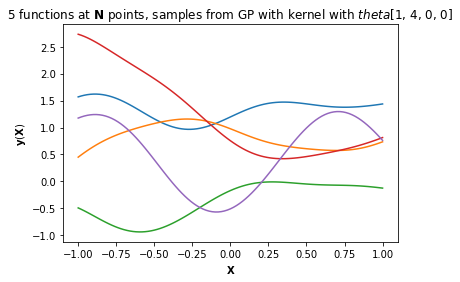

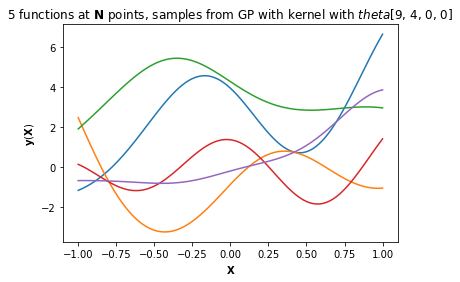

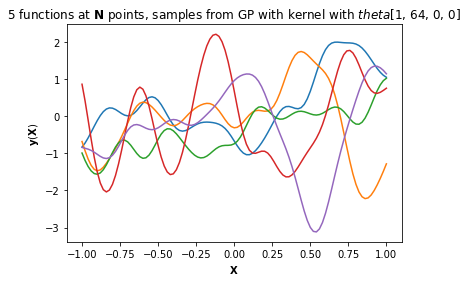

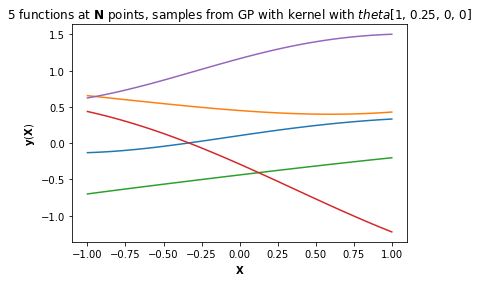

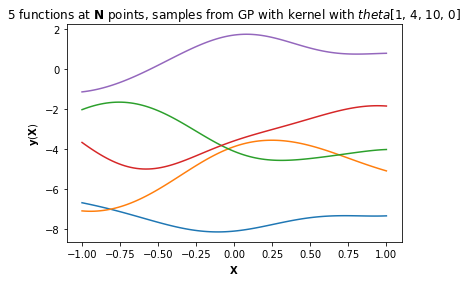

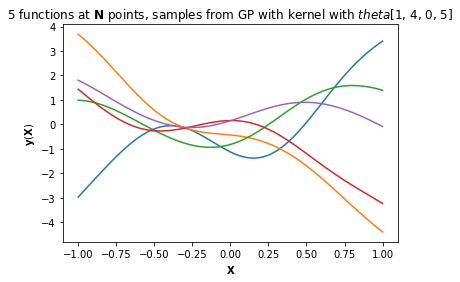

In [ ]:
"""
Plot curves with different values of theta.
"""
theta_values = [[1,4,0,0],[9,4,0,0],[1,64,0,0],[1,0.25,0,0],[1,4,10,0],[1,4,0,5]]
N = 101
X = np.linspace(-1, 1, N)

def plot_GP_kernel(X, N, theta_values, num_samples, num_plots):
    """
    Plot num_samples functions at N points, samples from GP with kernel
    Repeat num_plot times to plot 

    Parameters
    ----------
    X : (N,D) np.ndarray
        The array containing the data points.
    N : integer
        Number of points
    theta_values : List with the arrays containing the hyperparameters governing the kernel function for each plot.
    num_samples : The number of functions to plot.
    num_plots : The number of plots.

    Returns
    -------
    """
    for i in range(num_plots):
        Y = generate_curves_GP_prior(theta_values[i], num_samples)
        for j in range(num_samples):
            plt.plot(X, Y[j])
        plt.xlabel('$\mathbf{X}$')
        plt.ylabel('$\mathbf{y}(\mathbf{X})$')
        plt.title(str(num_samples)+' functions at $\mathbf{N}$ points, samples from GP with kernel with $theta$'+ str(theta_values[i]))
        plt.show()

num_plots = len(theta_values)
plot_GP_kernel(X,N,theta_values,5,num_plots)


Describe the differences between the plots. Explain in which way each of the kernel parameters affects the generated samples.

When increasing $\theta_0$ the effect of $\theta_1$ gets emphasized.

When increasing $\theta_0$ the effect of $\theta_1$ gets emphasized.W
hen increasing $\theta_1$ the wavelength decreases and the amplitude increases, when decreasing $\theta_1$ it becomes more smooth (almost linear).

When increasing $\theta_2$ is a contstant which only operates on the y-axis.

When increasing $\theta_3$, the values farther away from 0 become more extreme.


4. We now move to the bivariate case. Instead of an interval, we now consider a 2-D grid of equally spaced points of size $N = 21 \times 21$ in $[-1, 1] \times [-1, 1]$. We collect all these grid points in a data matrix $\mathbf{X}$, where each one of the 441 observations has two dimensions.

In [ ]:
"""
Compute the Gram matrix in the bivariate case.

Parameters
----------
K : np.ndarray
    The Gram matrix.
"""
N = 21
theta = [1,1,1,1]

def bivariate_Gram_matrix (N, theta):
    X_1 = np.linspace(-1, 1, num=N)
    X_2 = np.linspace(-1, 1, num=N)
    X1, X2 = np.meshgrid(X_1, X_2)
    Gram_matrix = np.zeros(shape=(N, N))
    for i in range(N):
        for j in range(N):
            Gram_matrix[i,j] = kernel(X1[i,j],X2[i,j],theta) 
    return X1, X2, Gram_matrix

_, _, K = bivariate_Gram_matrix (N, theta)

In [ ]:
"""
Tests for bivariate Gram matrix.
"""
assert type(K) is np.ndarray

What is the dimension of $\mathbf{K}$ now? What does this tell you about the scalability of sampling multivariate functions from Gaussian processes in higher dimensions?

Dimension of $\mathbf{K}$ is now $21$ x $21$. 

5. Using the same kernel from equation \eqref{eqn:kernel}, compute the Gram matrix $\mathbf{K}(\mathbf{X}, \mathbf{X})$ on the grid for each hyperparameter configuration $\mathbf{\theta} \in \{ (1, 1, 1, 1), (1, 10, 1, 1), (1, 1, 1, 10) \}$. For each $\mathbf{K}$, generate and plot four random surfaces from the Gaussian process prior  $\mathbf{y}(\mathbf{X}) \sim \mathcal{N}(\mathbf{0}, \mathbf{K}(\mathbf{X}, \mathbf{X}))$. Compare the observed differences to the univariate case.

In [ ]:
def generate_surfaces_GP_prior(N, theta, num_samples = 5):
    """
    Generate bivariate function samples (surfaces) from the Gaussian process prior.

    Parameters
    ----------
    theta : (4, ) array
        The array containing the hyperparameters governing the kernel function.
    num_samples : integer
        The number of functions to plot.

    Returns
    -------
    """
    # Kernel (bivariate) (of the data points)
    X1, X2, cov_matrix = bivariate_Gram_matrix(N, theta) 

    # Samples from the prior
    mu = np.zeros(N)
    Y = np.random.multivariate_normal(mean=mu, cov=cov_matrix, size=(num_samples,N))

    return X1, X2, Y

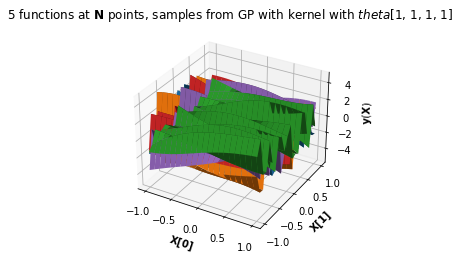

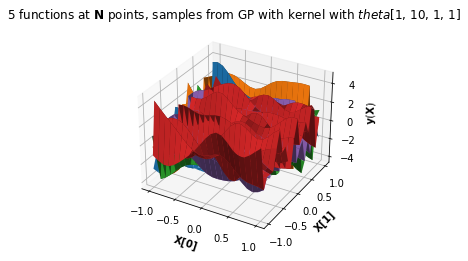

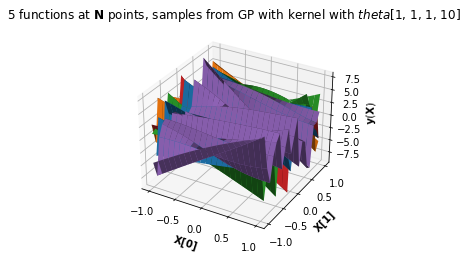

In [ ]:
"""
Plot curves with different values of theta.
"""
theta_values = theta_values = [[1,1,1,1],[1,10,1,1],[1,1,1,10]]

num_plots = len(theta_values)

def plot_GP_kernel_surface(N, theta_values, num_samples, num_plots):
    """
    Plot num_samples functions at N points, samples from GP with kernel
    Repeat num_plot times to plot 

    (Bivariate)

    Parameters
    ----------


    Returns
    -------
    """
    for i in range(num_plots):
        X1, X2, Y = generate_surfaces_GP_prior(N,theta_values[i], num_samples)
        for j in range(num_samples):
            ax = plt.gca(projection='3d')
            ax.plot_surface(X1,X2,Y[j])
        ax.set_xlabel('$\mathbf{X[0]}$')
        ax.set_ylabel('$\mathbf{X[1]}$')
        ax.set_zlabel('$\mathbf{y}(\mathbf{X})$')
        plt.title(str(num_samples)+' functions at $\mathbf{N}$ points, samples from GP with kernel with $theta$'+ str(theta_values[i]))
        plt.show()

num_plots = len(theta_values)
plot_GP_kernel_surface(N,theta_values,5,num_plots)

### Part 2 - Gaussian processes for regression
We would like to apply Gaussian process models to the problem of regression (Bishop 6.4.2). We consider a noisy model of the form:
$$$
t_n = y_n + \epsilon_n,
$$$
where $y_n = y(\mathbf{x}_n)$ and $\epsilon_n$ are i.i.d. samples from a random noise variable on the observed target values. Furthermore, we assume that the noise process has a Gaussian distribution given by:
$$$
    p(t_n | y_n) = \mathcal{N}(t_n | y_n, \beta^{-1})
$$$

Going back to a one-dimensional input space, we consider the following training data consisting of four data points:
$$$
	\mathcal{D} = \{ (x_1 = -0.5, t_1 = 0.5), (x_2 = 0.2, t_2 = -1), (x_3 = 0.3, t_3 = 3), (x_4 = -0.1, t_4 = -2.5)\}.
$$$
1. Just as before, compute the Gram matrix of the training data for $\mathbf{\theta} = (1, 1, 1, 1)$. Then, taking $\beta = 1$ in equation \eqref{eqn:gp_noise_process}, compute the covariance matrix $\mathbf{C}$ corresponding to the marginal distribution of the training target values: $p(\mathbf{t}) = \mathcal{N}(\mathbf{t} | \mathbf{0}, \mathbf{C})$.

In [ ]:
"""
Compute the marginal distribution covariance.

Parameters
----------
C : (4,4) np.ndarray
    The covariance matrix corresponding to the marginal distribution.
"""
theta = [1,1,1,1]
beta = 1
mean = 0

X = np.array([-0.5, 0.2, 0.3, -0.1])
T = np.array([0.5, -1, 3, -2.5])

N = 4

delta_nm = np.matrix([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
K = compute_Gram_matrix(X, theta)
C = np.array(K + (beta**-1 * delta_nm))


In [ ]:
"""
Tests to check the covariance matrix C.
"""
assert type(C) is np.ndarray
assert C.shape == (4,4)

2. Using the previous results, compute the mean and the covariance of the conditional distribution $p(t | \mathbf{t})$ of a new target value $t$ corresponding to the input $x = 0$. Which equations from Bishop do you need?

Equation 6.64:
Conditional distribution $p(t_{N+1}|\mathbf{t})$ we need the joint distribution $p(\mathbf{t}_{N+1})$

$$p(\mathbf{t}_{N+1}) = \mathcal{N}(\mathbf{t}_{N+1}|0, \mathbf{C}_{N+1})$$

Equation 6.65: Partition of the covariance matrix

$\mathbf{C}_{N+1} = $
$
 \begin{pmatrix}
C_N & \mathbf{k} \\
\mathbf{k}^T & c
\end{pmatrix}
$

$$c = k(\mathbf{x}_{N+1},\mathbf{x}_{N+1})+\beta^{-1}$$

-----
Equation 6.66, 6.67: Conditional distribution $p(t_{N+1}|\mathbf{t})$
$$= \mathcal{N}(t_{N+1}||\mathbf{k}^T \mathbf{C}^{-1}_N \mathbf{t}, c-\mathbf{k}^T \mathbf{C}^{-1}_N\mathbf{k})$$

with mean: $\mathbf{k}^T \mathbf{C}^{-1}_N \mathbf{t}$,
and covariance: $c-\mathbf{k}^T \mathbf{C}^{-1}_N\mathbf{k}$

Compute the mean and the covariance in the cell below. 

In [ ]:
"""
Compute the conditional predictive distribution.

Parameters
----------
m : float
    The mean of the conditional predictive distribution.
s2 : float
    The (co)variance of the conditional predictive distribution.
"""

X_new = list(X)
X_new.append(0)
K_new = kernel(np.array(X_new),np.array(X_new),theta)
m = np.dot(np.dot(K.T, np.linalg.inv(C)), T)[-1]
c = K_new + beta**-1
s2 = c - np.dot(np.dot(K.T,np.linalg.inv(C)),K)[-1,-1]

In [ ]:
"""
Tests to check the mean m and (co)variance s2.
"""
assert (type(m) is float) or (type(m) is np.float64)
assert (type(s2) is float) or (type(s2) is np.float64)

3. Does the mean of the conditional distribution $p(t | \mathbf{t})$ go to zero in the limit $x \rightarrow \pm \infty$? If so, explain why this happens. If not, how would you set the parameters $\mathbf{\theta}$ of the kernel function to make it happen?

In the limit of $x \rightarrow \pm \infty $, the conditional distribution is going to $- \infty$. 
Setting $\theta_2$ and $\theta_3$ to zero, then the conditional distribution will go to zero.